<a href="https://colab.research.google.com/github/yoshimethod/bioinformatics/blob/main/bioinformatics_pr5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import re
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader

In [2]:
!pip install transformers sentencepiece

In [3]:
!wget https://services.healthtech.dtu.dk/services/DeepLoc-1.0/deeploc_data.fasta -P ./data -q

In [4]:
!ls ./data

deeploc_data.fasta


In [5]:
!head -n 6 ./data/deeploc_data.fasta

>Q9H400 Cell.membrane-M test
MGLPVSWAPPALWVLGCCALLLSLWALCTACRRPEDAVAPRKRARRQRARLQGSATAAEASLLRRTHLCSLSKSDTRLHELHRGPRSSRALRPASMDLLRPHWLEVSRDITGPQAAPSAFPHQELPRALPAAAATAGCAGLEATYSNVGLAALPGVSLAASPVVAEYARVQKRKGTHRSPQEPQQGKTEVTPAAQVDVLYSRVCKPKRRDPGPTTDPLDPKGQGAILALAGDLAYQTLPLRALDVDSGPLENVYESIRELGDPAGRSSTCGAGTPPASSCPSLGRGWRPLPASLP
>Q5I0E9 Cell.membrane-M
MEVLEEPAPGPGGADAAERRGLRRLLLSGFQEELRALLVLAGPAFLAQLMMFLISFISSVFCGHLGKLELDAVTLAIAVINVTGISVGHGLSSACDTLISQTYGSQNLKHVGVILQRGTLILLLCCFPCWALFINTEQILLLFRQDPDVSRLTQTYVMVFIPALPAAFLYTLQVKYLLNQGIVLPQVITGIAANLVNALANYLFLHQLHLGVMGSALANTISQFALAIFLFLYILWRKLHHATWGGWSWECLQDWASFLQLAIPSMLMLCIEWWAYEVGSFLSGILGMVELGAQSITYELAIIVYMIPAGFSVAANVRVGNALGAGNIDQAKKSSAISLIVTELFAVTFCVLLLGCKDLVGYIFTTDWDIVALVAQVVPIYAVSHLFEALACTCGGVLRGTGNQKVGAIVNAIGYYVIGLPIGISLMFVAKLGVIGLWSGIIICSVCQTSCFLVFIARLNWKLACQQAQVHANLKVNVALNSAVSQEPAHPVGPESHGEIMMTDLEKKDEIQLDQQMNQQQALPVHPKDSNKLSGKQLALRRGLLFLGVVLVLVGGILVRVYIRTE
>P63033 Cell.membrane-M
MMKTLSSGNCTLNVPAKNSYRMVVLGASRVGKSSIVSRFLNGRFEDQYTPTIEDFHRKVY

In [6]:
!wc -l ./data/deeploc_data.fasta

28008 ./data/deeploc_data.fasta


In [7]:
!pip install Bio -q
import Bio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 279.2/279.2 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 24.9 MB/s eta 0:00:00


In [8]:
def read_fasta(file_path, columns):
  from Bio.SeqIO.FastaIO import SimpleFastaParser
  with open(file_path) as fasta_file:
    records = []
    for title, sequence in SimpleFastaParser(fasta_file):
      record = []
      title_splits =title.split(None)
      record.append(title_splits[0])
      sequence = "".join(sequence)
      record.append(sequence)
      record.append(len(sequence))
      location_splits = title_splits[1].split("-")
      record.append(location_splits[0])
      record.append(location_splits[1])

      if(len(title_splits) > 2):
        record.append(0)
      else:
        record.append(1)

      records.append(record)
  return pd.DataFrame(records, columns = columns)

In [26]:
data = read_fasta('./data/deeploc_data.fasta', columns = ['id', 'sequence', 'sequence_length', 'location', 'membrane', 'is_train'])
data.head()

,id,sequence,sequence_length,location,membrane,is_train
0,Q9H400,MGLPVSWAPPALWVLGCCALLLSLWALCTACRRPEDAVAPRKRARR...,295,Cell.membrane,M,0
1,Q5I0E9,MEVLEEPAPGPGGADAAERRGLRRLLLSGFQEELRALLVLAGPAFL...,566,Cell.membrane,M,1
2,P63033,MMKTLSSGNCTLNVPAKNSYRMVVLGASRVGKSSIVSRFLNGRFED...,266,Cell.membrane,M,1
3,Q9NR71,MAKRTFSNLETFLIFLLVMMSAITVALLSLLFITSGTIENHKDLGG...,780,Cell.membrane,M,1
4,Q86XT9,MGNCQAGHNLHLCLAHHPPLVCATLILLLLGLSGLGLGSFLLTHRT...,240,Cell.membrane,M,1


In [27]:
len(data)

14004

In [28]:
data['sequence_length'].describe()

count    14004.00000
mean       522.44166
std        448.06671
min         40.00000
25%        249.00000
50%        421.00000
75%        649.00000
max      13100.00000
Name: sequence_length, dtype: float64

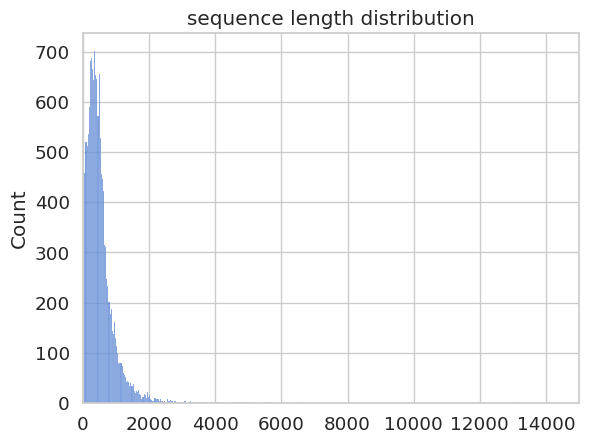

In [29]:
sns.set(style = 'whitegrid', palette = 'muted', font_scale=1.2)
ax = sns.histplot(data['sequence_length'].values)
ax.set_xlim(0, 15000)
plt.title(f'sequence length distribution')
plt.grid(True)

In [30]:
dataX = data[data['sequence_length'] < 1000]
len(dataX)

12614